<a href="https://colab.research.google.com/github/ytan42/Simple_NeuralNet_Python/blob/master/Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer

### Generate a toy dataset to test the neural network

In [59]:
# A simple data frame for testing purpose only
a = np.arange(1, 500)
b = np.arange(1, 500)
c = np.random.uniform(size = len(b))

df = pd.DataFrame({"a" : a,
                   "b" : b,
                   "c" : c})

# Added a random number to make prediction harder
df['d'] = ((df.a + df.b) * df.c) + np.random.normal(size = len(a))

print(df.head())
print(df.shape)

   a  b         c         d
0  1  1  0.121687  1.484646
1  2  2  0.394588 -0.910040
2  3  3  0.631512  3.779828
3  4  4  0.645079  4.443279
4  5  5  0.134499  1.843202
(499, 4)


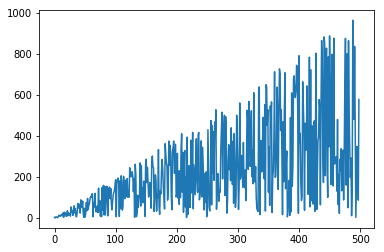

In [60]:
# Plot the data
plt.plot(df.d)
plt.show()

### Helper functions

In [0]:
# Weight initiation function
def init_weight(n, m):
    weight_matrix = np.random.uniform(low = 0.0, high = 1.0, size = (n, m))
    return(weight_matrix)

In [0]:
# Bias initiation function
def init_bias(m):
    bias_matrix = np.random.uniform(low = 0.0, high = 1.0, size = (m, 1))
    return(bias_matrix)

In [0]:
# The sigmoid function
def sigmoid(z):
    return(1 / (1 + np.exp(z * -1)))

# The detrivative of sigmoid function
def sigmoid_d(z):
    return(sigmoid(z) * (1 - sigmoid(z)))

In [0]:
# The Hyperbolic Tangent function
def tanh(z):
    return((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    
# The derivative of tanh function
def tanh_d(z):
    return(1-(tanh(z) ** 2))

In [0]:
# Mean squared error function
def mean_sqr_err(y, y_hat):
    out = sum(((y - y_hat) ** 2)) / len(y)
    return(out)

In [0]:
# Notation:
# xi - the ith row of data
# w1 - weights between input and 2nd layer
# b1 - biases of 2nd layer
# a2 - output of 2nd layer
# w2 - weights between 2nd and 3rd
# b2 - biases of 3rd layer
# a3 - output of 3rd layer
# w3 - weights between 3rd and output layer
# b3 - biases of output layer
# z4 - output of the network


# The feedforward function
def feedforward(xi, w1, b1, w2, b2, w3, b3):

  # Input layer - takes input from data
  a1 = xi

  # 2nd hidden layer
  z2 = np.dot(a1.T, w1) + b1.T
  a2 = tanh(z2)

  # 3rd hidden layer
  z3 = np.dot(a2, w2) + b2.T
  a3 = tanh(z3)

  # 4th and output layer. Only linear combination not activation function.
  z4 = np.dot(a3, w3) + b3

  # Output the prediction
  return({'w1' : w1,
          'z2' : z2,
          'w2' : w2,
          'z3' : z3,
          'w3' : w3,
          'z4' : z4,
          'a3' : a3,
          'a2' : a2,
          'a1' : a1})

In [0]:
# Backpropagation function (simple version)
def backpropagation(yi, forward):
    
    # Unpack variables
    z2 = forward['z2']
    w2 = forward['w2']
    z3 = forward['z3']
    w3 = forward['w3']
    z4 = forward['z4']
    
    # Output layer error - the derivative of 1/2(y - y_hat)^2
    d4 = -(yi - z4)
    
    # 3rd layer error
    d3 = np.dot(d4, w3.T) * tanh_d(z3)
    
    # 2nd layer error
    d2 = np.dot(d3, w2.T) * tanh_d(z2)
    
    return({'d4':d4, 
            'd3':d3, 
            'd2':d2})

In [0]:
# The prediction function is the feedforward
def predict_NN(x, model):
    
    # Unpack weights and biases from modell object
    w1 = model['w1']
    b1 = model['b1']  
    w2 = model['w2']
    b2 = model['b2'] 
    w3 = model['w3']
    b3 = model['b3']
    
    n_obs = x.shape[0]
    pred = []
    
    for obs in range(n_obs):
        
        xi = x.iloc[obs, :]
        y_hat = feedforward(xi=xi, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3)
        pred.append(y_hat['z4'][0][0])
    
    return(pred)

### The main build function

In [0]:
def build_NN(x, 
             y, 
             h1_neurons = 4, 
             h2_neurons = 2, 
             epoch_max = 50, 
             eta = 0.01, 
             batch_size = 10):
    
    # Initiate weights and biases 
    w1 = init_weight(n = x.shape[1], m = h1_neurons)
    b1 = init_bias(m = h1_neurons)
    
    w2 = init_weight(n = np.shape(w1)[1], m = h2_neurons)
    b2 = init_bias(m = h2_neurons)
    
    w3 = init_weight(n = np.shape(w2)[1], m = 1)
    b3 = init_bias(m = 1)
    
    n_obs = x.shape[0]
    n_batch = int(n_obs / batch_size) # Number of observations per batch
    
    error_epoch = [] # To record error for each batch
    
    for epoch in range(epoch_max):
        
        # Initiate weight and bias delta to matrix of 0s
        w3_delta = w3 * 0
        w2_delta = w2 * 0
        w1_delta = w1 * 0
        b3_delta = b3 * 0
        b2_delta = b2 * 0
        b1_delta = b1 * 0
        
        # Start stochastic batch gradient descent without replacement
        for batch in range(n_batch):
            
            # Randomly chose n ('batch_size') data points from input without
            # replacement.
            obs_batch = np.random.choice(n_obs, 
                                         batch_size, 
                                         replace = False)
            
            # For each observation, calculate weight and bias delta
            for obs in obs_batch:
                
                xi = x.iloc[obs, :].values
                yi = y.iloc[obs]
                
                forward = feedforward(xi=xi, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3)
                
                backprop = backpropagation(yi, forward)
                
                # Cumulate weight deltas
                w3_delta = w3_delta + np.dot(forward['a3'].T, backprop['d4'])
                w2_delta = w2_delta + np.dot(forward['a2'].T, backprop['d3'])
                w1_delta = w1_delta + np.dot(forward['a1'].reshape(3, 1), backprop['d2'])
                
                # Cumulate bias deltas
                b3_delta = b3_delta + backprop['d4']
                b2_delta = b2_delta + backprop['d3'].T
                b1_delta = b1_delta + backprop['d2'].T
                
            # Update weights and biases after finish one batch.
            # Then, use the updated weights and biases for the next batch.
            w1 = w1 - eta * (w1_delta / batch_size)
            w2 = w2 - eta * (w2_delta / batch_size)
            w3 = w3 - eta * (w3_delta / batch_size)
            b1 = b1 - eta * (b1_delta / batch_size)
            b2 = b2 - eta * (b2_delta / batch_size)
            b3 = b3 - eta * (b3_delta / batch_size)
        
        # At the each epoch, make prediction by using current weights and biases.
        epoch_predit = predict_NN(x, {'w1':w1, 'w2':w2, 'w3':w3, 'b1':b1, 'b2':b2, 'b3':b3})
        
        # Calculate mean sqr err so far for current epoch
        epoch_err = mean_sqr_err(y, epoch_predit)
        error_epoch.append(epoch_err)
        
    out = {'w1' : w1,
           'w2' : w2,
           'w3' : w3,
           'b1' : b1,
           'b2' : b2,
           'b3' : b3,
           'error_epoch' : error_epoch}
    
    return(out)

### Make a neural network and make prediction

Number of neuron in input = 3

Number of neuron in 2nd layer = 4

Number of neuron in 3rd layer = 2

Number of neuron in output layer = 1

In [0]:
# Normalise data by using sklearn normalizer function
transformer = Normalizer().fit(df)
df_norm = pd.DataFrame(transformer.transform(df))

x_norm = df_norm.iloc[:, 0:3]
y_norm = df_norm.iloc[:, 3]    

In [62]:
print(x_norm.head())
print(y_norm.head())

          0         1         2
0  0.486851  0.486851  0.059244
1  0.667265  0.667265  0.131647
2  0.524736  0.524736  0.110459
3  0.553855  0.553855  0.089320
4  0.684127  0.684127  0.018403
0    0.722802
1   -0.303619
2    0.661137
3    0.615233
4    0.252197
Name: 3, dtype: float64


In [0]:
# Call the build_NN function to build nerual network
nn_out = build_NN(x_norm, 
                  y_norm, 
                  h1_neurons = 4, 
                  h2_neurons = 3, 
                  epoch_max = 500, 
                  eta = 0.01, 
                  batch_size = 20)

nn_pred = predict_NN(x_norm, nn_out)

In [64]:
mean_sqr_err(y_norm, nn_pred)

0.006259763881676287

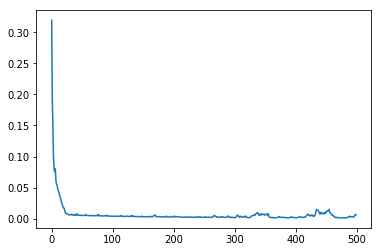

In [65]:
# Plot the error
plt.plot(nn_out['error_epoch'])
plt.show()

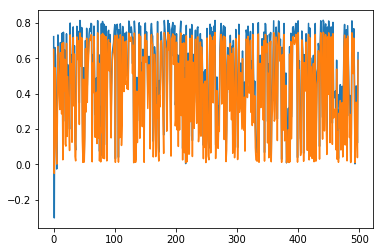

In [67]:
# Plot actual vs predicted
nn_pred_df = pd.DataFrame({'y':y_norm, 'y_hat':nn_pred})
plt.plot(nn_pred_df['y'])
plt.plot(nn_pred_df['y_hat'])
plt.show()